In [1]:
%config InlineBackend.figure_formats = ['retina', 'pdf']

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# python imports
import os
from pprint import pprint
from random import shuffle
import imageio
import progressbar as pb

print("Numpy {}".format(np.__version__))
print("Tensorflow {}".format(tf.__version__))
print(" Keras {}".format(tf.keras.__version__))

print("\nAdditional Modules:")
print("progressbar2 {}".format(pb.__version__))

np.set_printoptions(precision=5, suppress=True)

# build keras model
gpu_options = tf.GPUOptions(allow_growth=True) # allow growth to not reserve complete memory of gpu
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.set_session(sess)

Numpy 1.16.2
Tensorflow 1.13.1
 Keras 2.2.4-tf

Additional Modules:
progressbar2 3.39.3


In [2]:
#config_modelname="sigmoid-190509"
#config_modelname="relu-190509"
config_modelname="tanh-190509"

#activation_function = keras.activations.sigmoid
#activation_function = keras.activations.relu
activation_function = keras.activations.tanh

config = dict(
    logdir="./output/ml_log/",
    inputfolder="./input/classes_r3",
    checkpoint="./output/ml_log/tensorflow_checkpoint.h5",
    model="./output/{}.h5".format(config_modelname),
    model_map="./output/{}.map".format(config_modelname),
    split_train=0.85,
)
pprint(config)

os.makedirs(config["logdir"], exist_ok=True)

{'checkpoint': './output/ml_log/tensorflow_checkpoint.h5',
 'inputfolder': './input/classes_r3',
 'logdir': './output/ml_log/',
 'model': './output/tanh-190509.h5',
 'model_map': './output/tanh-190509.map',
 'split_train': 0.85}


In [3]:
def parse_file(path, label):
    #label = tf.string_split([path], delimiter=os.sep).values[-2]
    image_string = tf.read_file(path)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image_decoded = tf.image.per_image_standardization(image_decoded)
    image_resized = tf.image.resize_images(image_decoded, [100, 100])
    return image_resized, label

# collect subfolders of inputfolder
# util.recursive_collect(config["inputfolder"])
directories = [os.path.join(config["inputfolder"], child) for child in os.listdir(config["inputfolder"])]
paths = []
labels = []
label_name = dict()
for directory, label in zip(directories, range(len(directories))):
    children = os.listdir(directory)
    paths.extend([os.path.join(directory, child) for child in children])
    labels.extend([int(label)] * len(children))
    label_name[label] = (len(children), directory.split(os.sep)[-1])

split_train = int(config["split_train"] * len(paths))
    
# create lookup table to get integer indices
# https://www.tensorflow.org/api_docs/python/tf/contrib/lookup/index_table_from_tensor
classes = list(map(lambda x: x.split(os.sep)[-1], directories))
print("total images: {}".format(len(paths)))
pprint(label_name)

#for p,l in zip(paths, labels):
#    print("{} -> {}: {}".format(p, l, label_name[l]))

# create final dataset
dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
dataset = dataset.map(parse_file, num_parallel_calls=os.cpu_count())
dataset = dataset.cache(filename=r"c:\temp\tf_cache")
dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

# split off a dataset for training
train_dataset = dataset.take(split_train)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)

# split validation set off and use rest for test
test_dataset = dataset.skip(split_train)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(32)

#iterator = dataset.make_one_shot_iterator()
#with tf.Session() as sess:
#    print(sess.run(iterator.get_next()))

total images: 2094
{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
print("loading model")
model = keras.models.load_model(config["model"])

# load label mapping from file
import yaml
with open(config["model_map"], 'r') as f:
    label_name = yaml.load(f, Loader=yaml.FullLoader)

model.summary()
print("done.")

loading model
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2560256   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_____________

Layername: layer1
{'activation': 'tanh',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'dtype': 'float32', 'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense',
 'trainable': True,
 'units': 256,
 'use_bias': True}
Layer Weights: (256, 10000) -> (256, 100, 100)


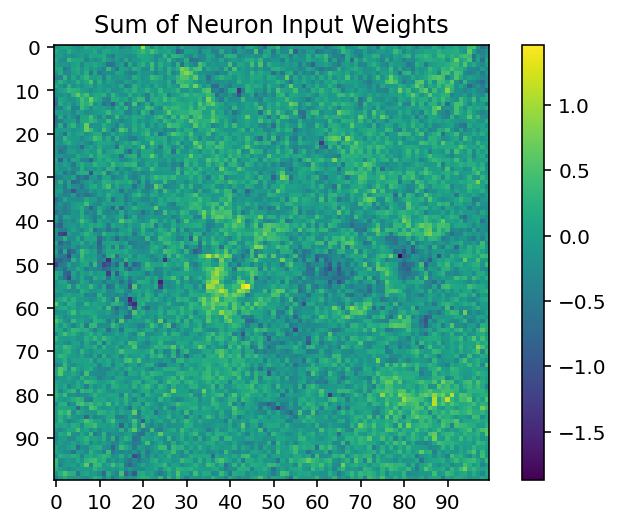

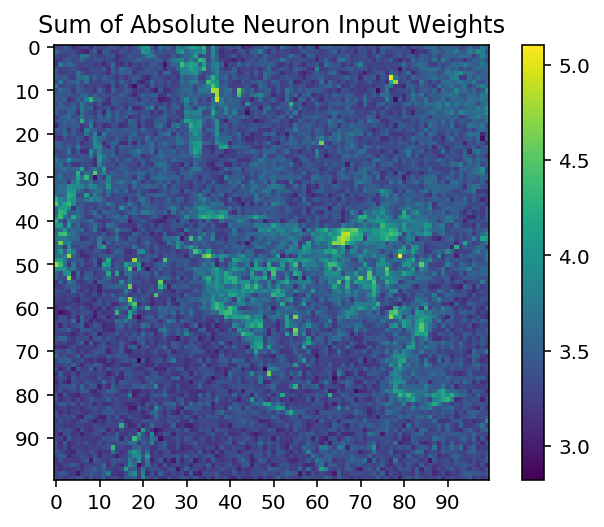

Neuron 0


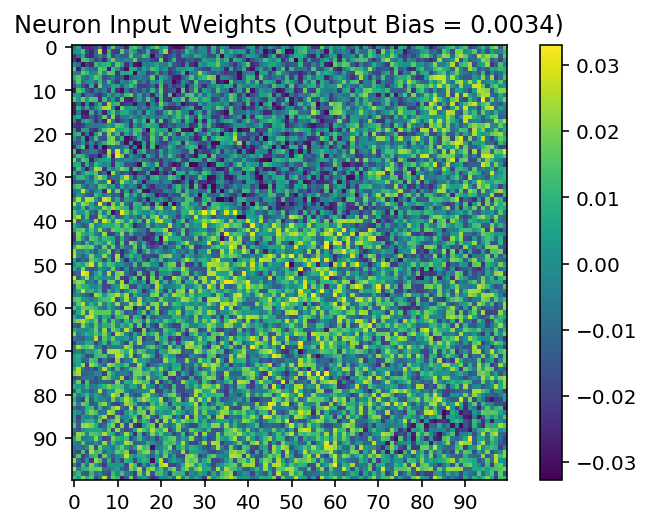

Neuron 1


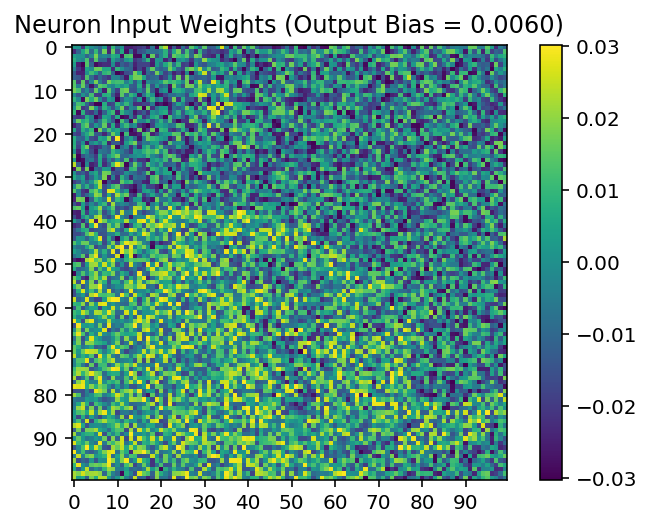

Layername: layer2
{'activation': 'tanh',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'dtype': 'float32', 'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_1',
 'trainable': True,
 'units': 128,
 'use_bias': True}
Layer Weights: (128, 256) -> (128, 16, 16)


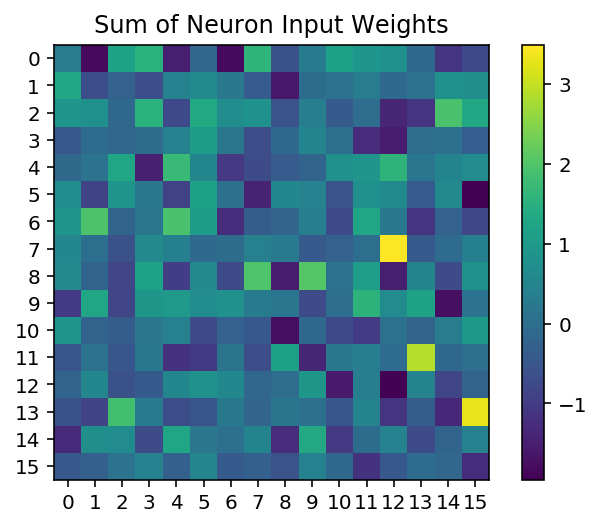

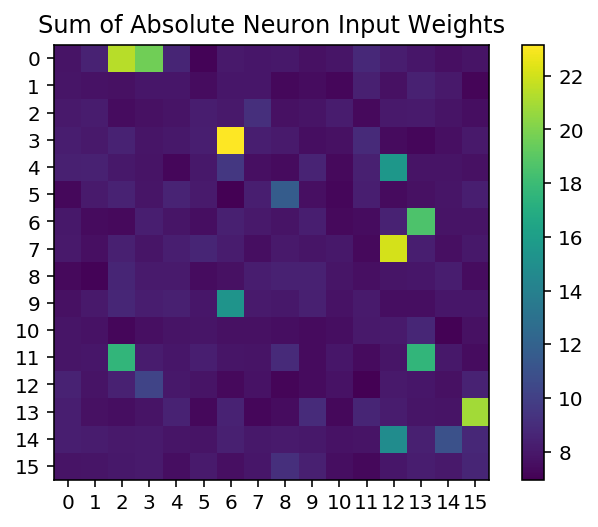

Neuron 0


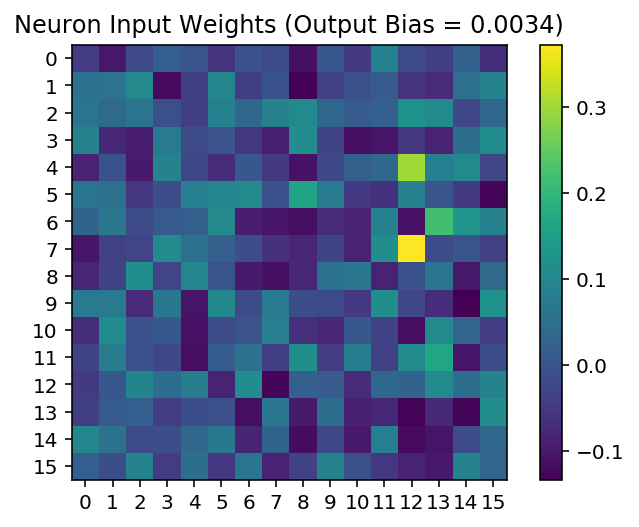

Neuron 1


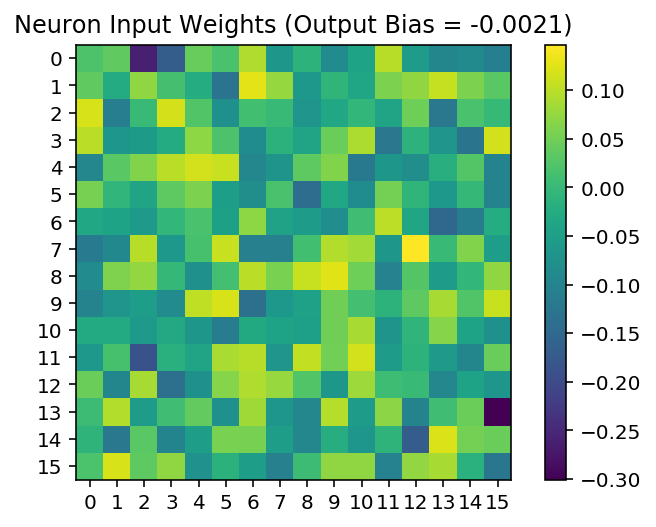

Layername: layer1
{'activation': 'tanh',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'dtype': 'float32', 'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense',
 'trainable': True,
 'units': 256,
 'use_bias': True}
Layer Weights: (256, 10000) -> (256, 100, 100)


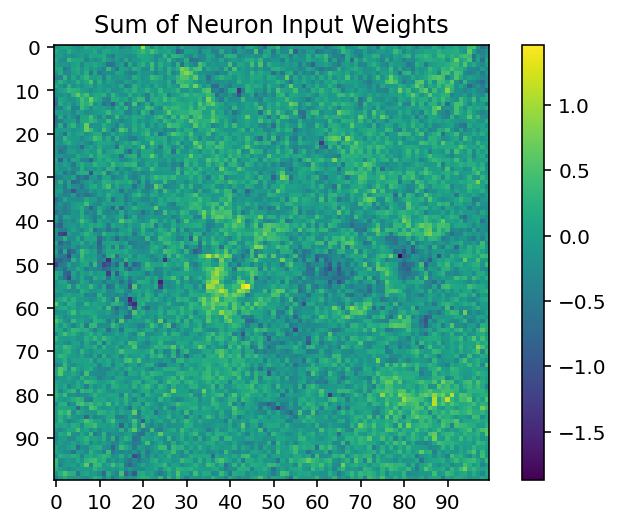

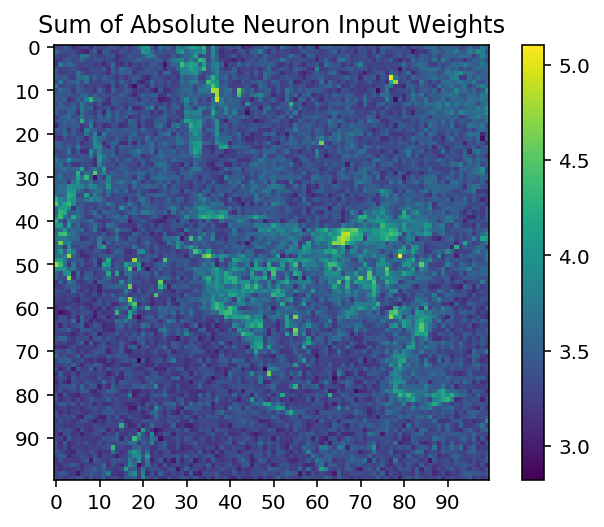

Neuron 241


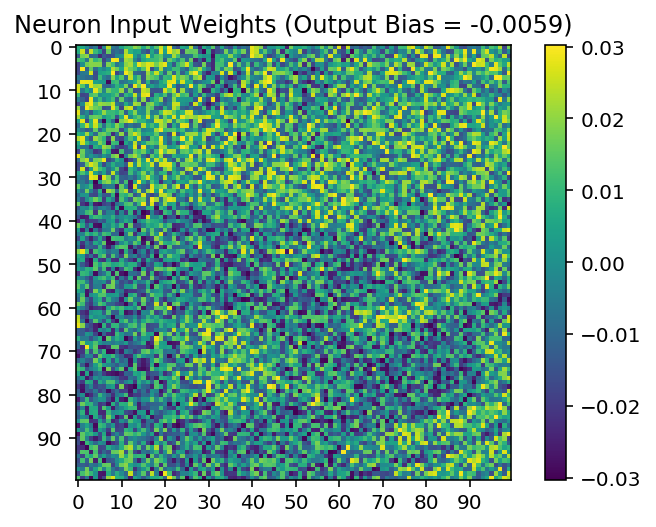

Layername: layer6
{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'dtype': 'float32', 'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_4',
 'trainable': True,
 'units': 12,
 'use_bias': True}
Layer Weights: (12, 16) -> (12, 4, 4)


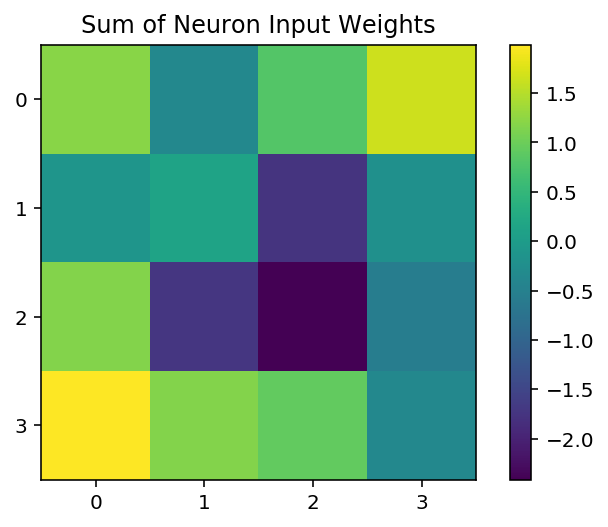

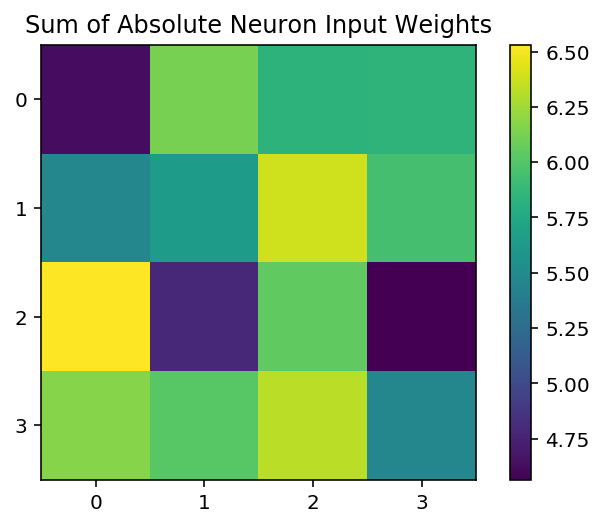

Neuron 0


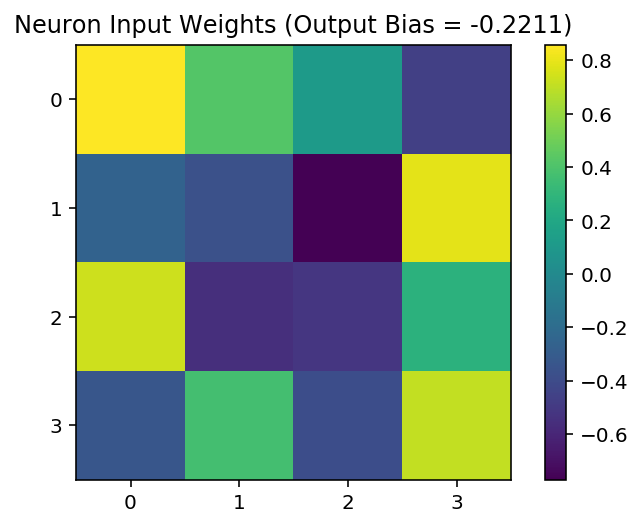

Neuron 1


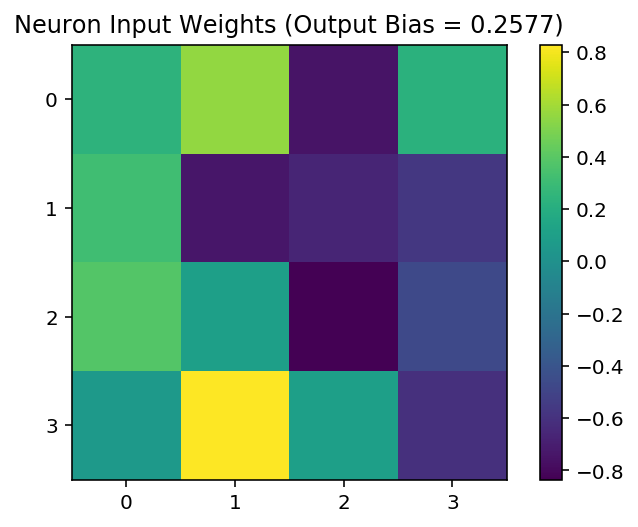

Neuron 2


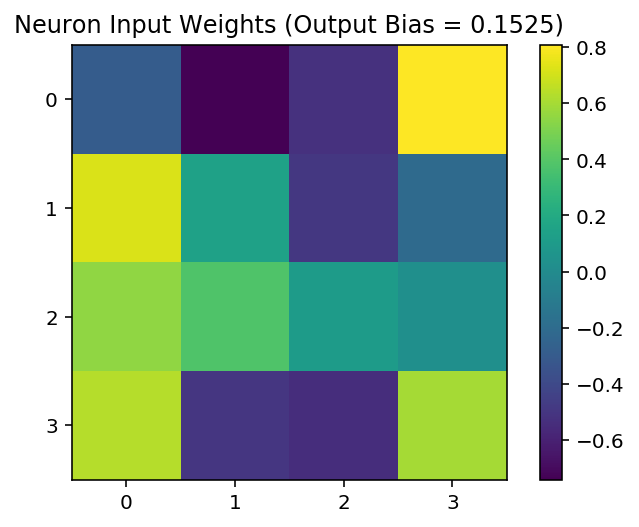

Neuron 3


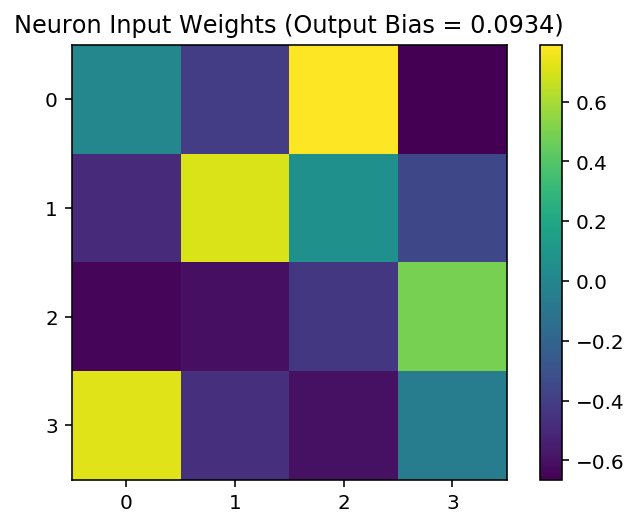

Neuron 4


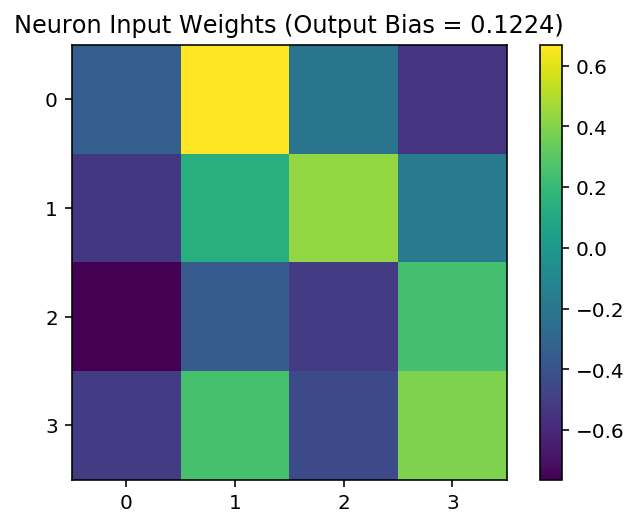

Neuron 5


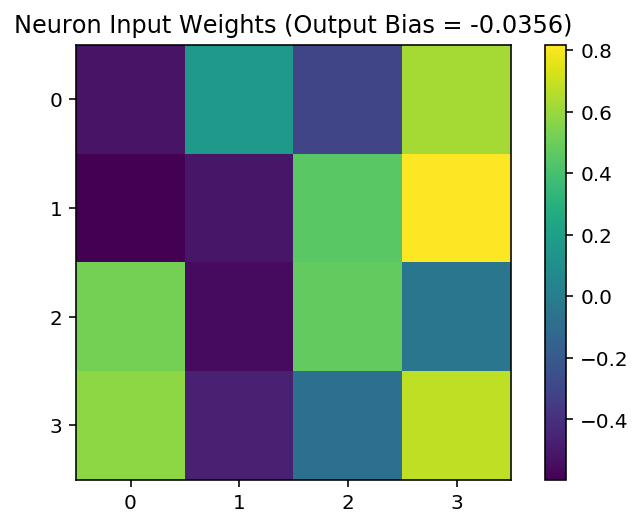

Neuron 6


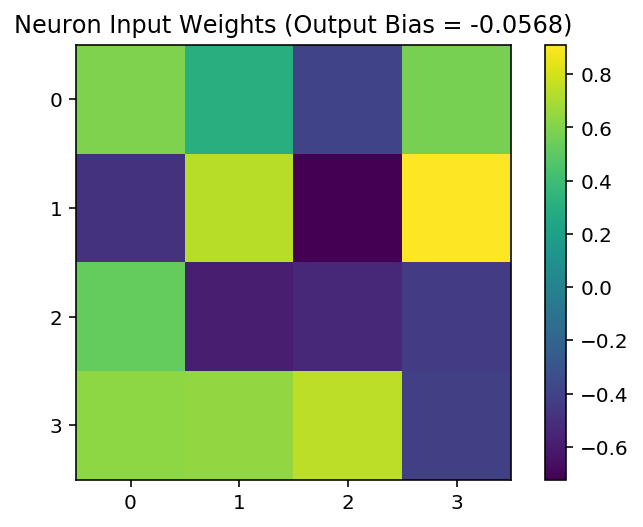

Neuron 7


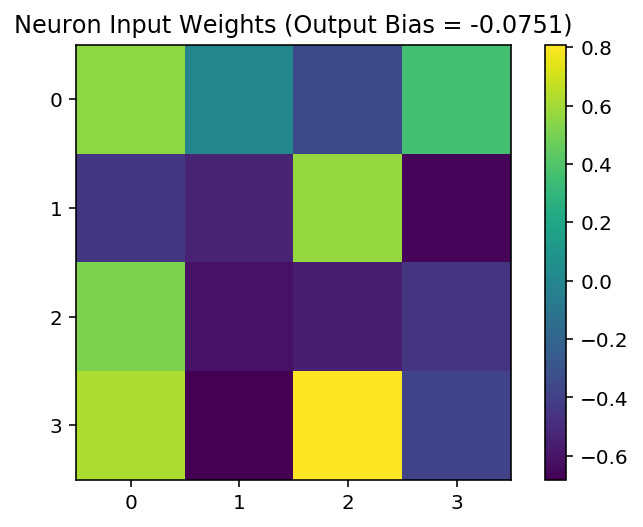

Neuron 8


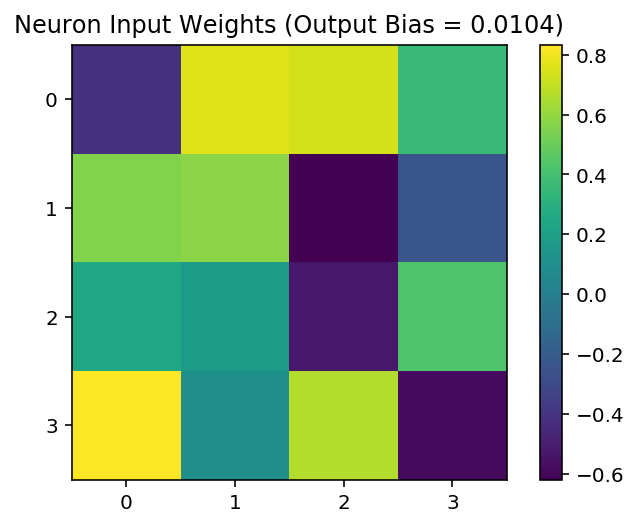

Neuron 9


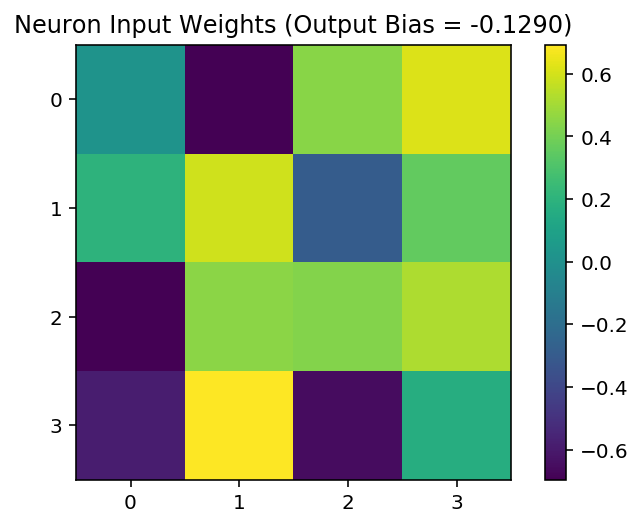

Neuron 10


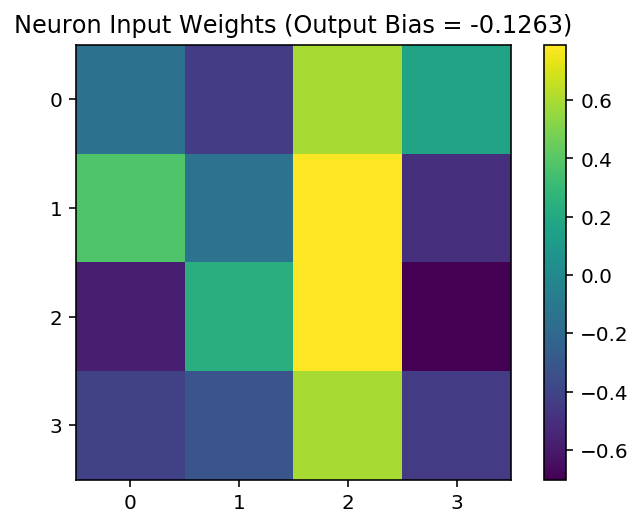

Neuron 11


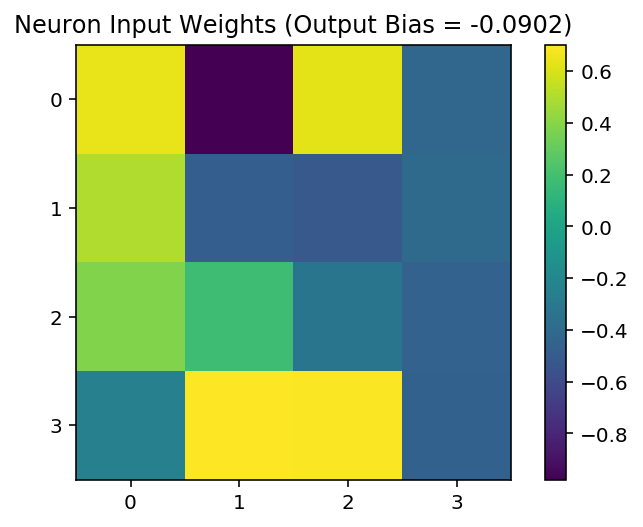

In [7]:
def visualize(layer, reshape, save_prefix, start_index, end_index, tick_stepsize):
    print("Layername: {}".format(save_prefix))
    pprint(layer.get_config())
    first = layer.get_weights()

    # input weights and output bias
    layer_weights = np.moveaxis(first[0],1,0)
    layer_bias = first[1]

    # reshape weights
    print("Layer Weights: {} -> {}".format(layer_weights.shape, reshape))
    layer_weights = np.reshape(layer_weights,reshape)

    # calculate sums
    weight_sum = np.sum(layer_weights, 0, keepdims=False)
    abs_weight_sum = np.sum(np.abs(layer_weights), 0, keepdims=False)

    # setup plot
    fig, ax = plt.subplots()
    im = ax.imshow(weight_sum, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.xaxis.set_ticks(np.arange(0, reshape[1], tick_stepsize))
    ax.yaxis.set_ticks(np.arange(0, reshape[2], tick_stepsize))
    ax.set(title="Sum of Neuron Input Weights")
    plt.savefig("visu-{}-normalized.svg".format(save_prefix), format="svg", bbox_inches='tight')

    # setup plot
    fig, ax = plt.subplots()
    im = ax.imshow(abs_weight_sum, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.xaxis.set_ticks(np.arange(0, reshape[1], tick_stepsize))
    ax.yaxis.set_ticks(np.arange(0, reshape[2], tick_stepsize))
    ax.set(title="Sum of Absolute Neuron Input Weights")
    plt.savefig("visu-{}-absolute.svg".format(save_prefix), format="svg", bbox_inches='tight')
    plt.show()

    for weights, bias, index in zip(layer_weights[start_index:end_index], layer_bias[start_index:end_index], range(start_index, end_index)):
        # setup plot
        fig, ax = plt.subplots()
        im = ax.imshow(weights, interpolation='nearest')
        ax.figure.colorbar(im, ax=ax)
        ax.xaxis.set_ticks(np.arange(0, reshape[1], tick_stepsize))
        ax.yaxis.set_ticks(np.arange(0, reshape[2], tick_stepsize))
        ax.set(title="Neuron Input Weights (Output Bias = {:.4f})".format(bias))

        # save and show
        plt.savefig("visu-{}-weight-{}.svg".format(save_prefix, index), format="svg", bbox_inches='tight')
        print("Neuron {}".format(index))
        plt.show()
        
visualize(model.layers[1], (256, 100, 100), "layer1", 0, 2, 10)
visualize(model.layers[2], (128,  16,  16), "layer2", 0, 2, 1)
visualize(model.layers[1], (256, 100, 100), "layer1", 241, 242, 10)
visualize(model.layers[6], (12, 4, 4), "layer6", 0, 12, 1)

In [6]:
np.set_printoptions(precision=5,threshold=5)

def result_to_color(prediction, index, predicted_label, label):
    if label == index:
        color = (32,(0,255,0))
    else:
        if prediction[index] > 1e-4:
            if index == predicted_label:
                color = (31,(0,0,255))
            else:
                color = (33,(0,255,255))
        else:
            color = (30,(128,0,0))
    return color

def pprint_result(prediction, label, img=None):
    predicted_label = np.argmax(prediction)
    if img is not None:
        plt.imshow(np.squeeze(img), "gray"), plt.show();
    
    confusion_labels.append(label)
    confusion_predictions.append(predicted_label)
    
    put = prediction[0]
    color = result_to_color(prediction, 0, predicted_label, label)
    str = "[\x1b[{}m{:.4f}".format(color[0], put)
    for j in range(1, len(prediction)):
        put = prediction[j]
        color = result_to_color(prediction, j, predicted_label, label)
        str += " \x1b[{}m{:.4f}".format(color[0], put)
    str += "\x1b[0m] {} ({}<>{})".format(label_name[label][1], label, predicted_label)
    print(str)
    return str

confusion_labels = list()
confusion_predictions = list()

pprint(label_name)
iterator = test_dataset.make_one_shot_iterator()
try:
    count = 0
    while count < 50:
        count += 1
        el = iterator.get_next()
        with tf.Session() as sess:
            el = sess.run(el)
        labels = el[1]
        images = el[0]
        for img, lab in zip(images, labels):
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img, steps=1) # is single image, so no more steps
            pprint_result(pred[0], lab)#, img)
except tf.errors.OutOfRangeError:
    pass
np.set_printoptions(precision=5, threshold=None)

{0: (129, '1_home'),
 1: (128, '2.1_moving'),
 2: (117, '2.2_moving_wafer'),
 3: (188, '3.1_cassette_location_empty'),
 4: (198, '3.2_cassette_location_unknown'),
 5: (163, '3.3_cassette_location_wafer'),
 6: (399, '4.1_processchamber_empty'),
 7: (206, '4.2_processchamber_unknown'),
 8: (141, '4.3_processchamber_wafer'),
 9: (106, '5.1_cooling_station_wafer'),
 10: (149, '5.2_cooling_station_unknown'),
 11: (170, '5.3_cooling_station_empty')}
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0141 0.9539 0.0013 0.0003 0.0106 0.0002 0.0015 0.0016 0.0031 0.0003 0.0

[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0019 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0002 0.0001 0.9836 0.0006 0.0001 0.0066 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9640] 5.3_cooling_station_empty (11<>11)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0042 0.9285 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0475] 2.1_moving (1<>1)
[0.0012 0.0082 0.0001 0.0000 0.0000 0.0003 0.9858 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 

[0.0001 0.0035 0.0041 0.0015 0.0001 0.0001 0.0031 0.0020 0.9845 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0076 0.0000 0.0000 0.0000 0.0003 0.9866 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0002 0.0163 0.0002 0.0002 0.0002 0.0030 0.0071 0.9714 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0013 0.0091 0.0001 0.0000 0.0000 0.0003 0.9846 0.0024 0.0020 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0007 0.9416 0.0017 0.0000 0.0002 0.0001 0

[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0324 0.9204 0.0002 0.0002 0.0050 0.0001 0.0069 0.0075 0.0008 0.0001 0.0002 0.0262] 2.1_moving (1<>1)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0001 0.0034 0.0041 0.0015 0.0001 0.0001 0.0030 0.0020 0.9846 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001

[0.0040 0.0034 0.0002 0.0124 0.9759 0.0019 0.0001 0.0007 0.0002 0.0010 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0141 0.9538 0.0013 0.0003 0.0107 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0129] 2.1_moving (1<>1)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0025 0.0242 0.0002 0.0000 0.0001 0.0003 0.9651 0.0031 0.0038 0.0000 0.0000 0.0006] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0053 0.0063 0.0001 0.0067 0.9774 0.0022 0.0001

[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0034 0.0359 0.0002 0.0000 0.0001 0.0004 0.9509 0.0034 0.0047 0.0000 0.0000 0.0009] 4.1_processchamber_empty (6<>6)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0001 0.0035 0.0039 0.0017 0.0001 0.0002 0.0035 0.0022 0.9838 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0160 0.0002 0.0002 0.0002 0.0030 0.0072 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.00

[0.0000 0.0000 0.0003 0.9863 0.0089 0.0003 0.0000 0.0012 0.0015 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0008 0.0300 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0011 0.0003 0.0025 0.9641] 5.3_cooling_station_empty (11<>11)
[0.0055 0.0068 0.0001 0.0062 0.9771 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0002 0.0160 0.0002 0.0002 0.0002 0.0030 0.0072 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0077 0.0001 0.0000 0.0

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0012 0.0082 0.0001 0.0000 0.0000 0.0003 0.9858 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0043 0.9283 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0476] 2.1_moving (1<>1)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 

[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0041 0.9295 0.0002 0.0000 0.0004 0.0000 0.0083 0.0078 0.0025 0.0000 0.0004 0.0467] 2.1_moving (1<>1)
[0.0002 0.0160 0.0002 0.0002 0.0002 0.0030 0.0072 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0159 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0323 0.9248 0.0003 0.0002 0.0052 0.0001 0.0058 0.0062 0.0008 0.0001 0.0002 0.0240] 2.1_moving (1<>1)
[0.0000 0.0000 0.0004 0.9853 0.0097 0.0003 0.0000 0.0012 0.0015 0.0006 0.0008 0.0001] 3.1_cassette_l

[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9706 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0001 0.0151 0.0093 0.0122 0.0021 0.0064 0.0190 0.2364 0.6761 0.0001 0.0206 0.0024] 4.3_processchamber_wafer (8<>8)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0009 0.0001 0.0082 0.0018 0.0014 0.0003 0.0001 0.0000 0.0010 0.9842 0.0012 0.0009] 5.1_cooling_station_wafer (9<>9)
[0.0012 0.0079 0.0001 0.0000 0.0000 0.0003 0.9862 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9857 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.985

[0.0034 0.0359 0.0002 0.0000 0.0001 0.0004 0.9509 0.0034 0.0047 0.0000 0.0000 0.0009] 2.1_moving (1<>6)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0034 0.0359 0.0002 0.0000 0.0001 0.0004 0.9510 0.0034 0.0047 0.0000 0.0000 0.0009] 2.1_moving (1<>6)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0055 0.0069 0.0001 0.0062 0.9770 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0055 0.0067 0.0001 0.0063 0.9772 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0161 0.0002 0.0002 0.0002 0.0030 0.0072 0.9715 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0026 0.0254 0.0002 0.0000 0.0001 0.0003 0.9636 0.0031 0.0039 0.0000 0.0000 0.0006] 4.1_processchamber_empty (6<>6)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9859 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.001

[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0027 0.0260 0.0002 0.0000 0.0001 0.0003 0.9629 0.0031 0.0040 0.0000 0.0000 0.0006] 4.1_processchamber_empty (6<>6)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 2.2_moving_wafer (2<>9)
[0.0000 0.0000 0.0003 0.9859 0.0088 0.0003 0.0000 0.0013 0.0017 0.0005 0.0009 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0055 0.0049 0.0002 0.0084 0.9756 0.0033 0.0001 0.0011 0.0001 0.0006 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9705 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.

[0.0001 0.0138 0.0084 0.0133 0.0021 0.0065 0.0206 0.2383 0.6748 0.0001 0.0196 0.0023] 4.2_processchamber_unknown (7<>8)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0055 0.0053 0.0001 0.0078 0.9762 0.0030 0.0001 0.0010 0.0001 0.0006 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0175 0.0002 0.0002 0.0003 0.0028 0.0067 0.9707 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.00

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9857 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0064 0.9639 0.0010 0.0001 0.0033 0.0001 0.0015 0.0016 0.0032 0.0001 0.0003 0.0185] 2.1_moving (1<>1)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0028 0.0272 0.0002 0.0000 0.0001 0.0003 0.9614 0.0032 0.0041 0.0000 0.0000 0.0007] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0001 0.0035 0.0041 0.0015 0.0001 0.0001 0.0031 0.0020 0.9845 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0002 0.0176 0.0002 0.0002 0.0003 0.0028 0.0067 0.9706 

[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0042 0.9291 0.0002 0.0000 0.0004 0.0000 0.0086 0.0079 0.0025 0.0000 0.0004 0.0468] 2.1_moving (1<>1)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:408: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next()` once outside the loop, and use `next_element` as the input to some computation that is invoked inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0000 0.0003 0.9863 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9861 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0055 0.0069 0.0001 0.0062 0.9769 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0002 0.0001 0.9835 0.0006 0.0

[0.0002 0.0170 0.0002 0.0002 0.0003 0.0029 0.0069 0.9710 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0118 0.9588 0.0012 0.0002 0.0079 0.0001 0.0014 0.0015 0.0028 0.0002 0.0003 0.0138] 2.1_moving (1<>1)
[0.0000 0.0002 0.0010 0.0008 0.0004 0.0001 0.0000 0.0011 0.0009 0.0025 0.9852 0.0078] 5.2_cooling_station_unknown (10<>10)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0012 0.0081 0.0001 0.0000 0.0000 0.0003 0.9859 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0001 0.0036 0.0038 0.0019 0.0001 0.0002 0.0039 0.0025 0.9830 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0076 0.0000 0.0000 0.0000 0.0003 0.9865 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0

[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0002 0.0158 0.0002 0.0002 0.0002 0.0030 0.0073 0.9717 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0082 0.0001 0.0000 0.0000 0.0003 0.9858 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0027 0.0258 0.0002 0.0000 0.0001 0.0003 0.9632 0.0031 0.0040 0.0000 0.0000 0.0006] 4.1_processchamber_empty (6<>6)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.00

[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0002 0.0180 0.0002 0.0002 0.0003 0.0027 0.0066 0.9702 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0043 0.9283 0.0002 0.0000 0.0004 0.0000 0.0084 0.0079 0.0024 0.0000 0.0004 0.0476] 2.1_moving (1<>1)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.9712 0.0105 0.0001 0.0003 0.0109 0.0016 0.0045 0.0002 0.0001 0.0003 0.0000 0.0003] 1_home (0<>0)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0001 0.0033 0.0044 0.0015 0.0001 0.0001 0.0027 0.0019 0.9849 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0

[0.0000 0.0001 0.0133 0.0042 0.0015 0.0030 0.0005 0.0008 0.0073 0.1229 0.8410 0.0054] 5.2_cooling_station_unknown (10<>10)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0000 0.0000 0.0003 0.9862 0.0091 0.0003 0.0000 0.0012 0.0014 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0141 0.9539 0.0013 0.0003 0.0106 0.0002 0.0015 0.0016 0.0031 0.0003 0.0003 0.0130] 2.1_moving (1<>1)
[0.0001 0.0035 0.0039 0.0017 0.0001 0.0002 0.0035 0.0022 0.9838 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0

[0.0000 0.0000 0.0003 0.9862 0.0091 0.0003 0.0000 0.0012 0.0014 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0002 0.0177 0.0002 0.0002 0.0003 0.0028 0.0067 0.9705 0.0007 0.0000 0.0004 0.0004] 4.2_processchamber_unknown (7<>7)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0002 0.0003 0.9512 0.0011 0.0004 0.0375 0.0001 0.0006 0.0019 0.0056 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0002 0.0003 0.9473 0.0011 0.0004 0.0412 0.0001 0.0007 0.0019 0.0057 0.0010 0.0001] 2.2_moving_wafer (2<>2)
[0.0053 0.0063 0.0001 0.0067 0.9774 0.0022 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.

[0.0002 0.0159 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0002 0.0001 0.9835 0.0006 0.0001 0.0067 0.0003 0.0001 0.0019 0.0064 0.0001 0.0001] 2.2_moving_wafer (2<>2)
[0.0011 0.0001 0.0079 0.0023 0.0018 0.0003 0.0001 0.0000 0.0011 0.9830 0.0013 0.0011] 5.1_cooling_station_wafer (9<>9)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0019 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0055 0.0069 0.0001 0.0062 0.9770 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0055 0.0049 0.0002 0.0084 0.9755 0.0033 0.0001 0.0011 0.0001 0.0006 0.0002 0.0001] 3.3_cassette_location_wafer (5<>4)
[0.0002 0.0159 0.0002 0.0002 0.0002 0.0030 0.0073 0.9716 0.0007 0.0000 0.0004 0.0003] 4.2_processchamber_unknown (7<>7)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.986

[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0001 0.0034 0.0043 0.0014 0.0001 0.0001 0.0028 0.0018 0.9850 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0017 0.0001 0.0072 0.0005 0.0017 0.9858 0.0005 0.0023 0.0002 0.0001 0.0001 0.0000] 3.3_cassette_location_wafer (5<>5)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0012 0.0072 0.0000 0.0000 0.0000 0.0003 0.9872 0.0023 0.0016 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0004 0.0000 0.0097 0.0007 0.0006 0.0003 0.0001 0.0000 0.0009 0.9859 0.0009 0.0004] 5.1_cooling_station_wafer (9<>9)
[0.0042 0.9286 0.0002 0.0000 0.0004 0.00

[0.0001 0.0038 0.0035 0.0023 0.0001 0.0002 0.0049 0.0030 0.9811 0.0001 0.0002 0.0006] 4.3_processchamber_wafer (8<>8)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0003 0.9860 0.0024 0.0018 0.0000 0.0000 0.0002] 4.1_processchamber_empty (6<>6)
[0.0008 0.0302 0.0001 0.0001 0.0000 0.0000 0.0003 0.0007 0.0010 0.0002 0.0024 0.9639] 5.3_cooling_station_empty (11<>11)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0077 0.0001 0.0000 0.0000 0.0003 0.9864 0.0024 0.0017 0.0000 0.0000 0.0001] 4.1_processchamber_empty (6<>6)
[0.0000 0.0000 0.0003 0.9862 0.0087 0.0003 0.0000 0.0013 0.0016 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0055 0.0067 0.0001 0.0063 0.9772 0.0023 0.0001 0.0008 0.0001 0.0007 0.0002 0.0001] 3.2_cassette_location_unknown (4<>4)
[0.0000 0.0000 0.0003 0.9862 0.0091 0.0003 0.0000 0.0012 0.0014 0.0005 0.0008 0.0001] 3.1_cassette_location_empty (3<>3)
[0.0012 0.0080 0.0001 0.0000 0.0000 0.0

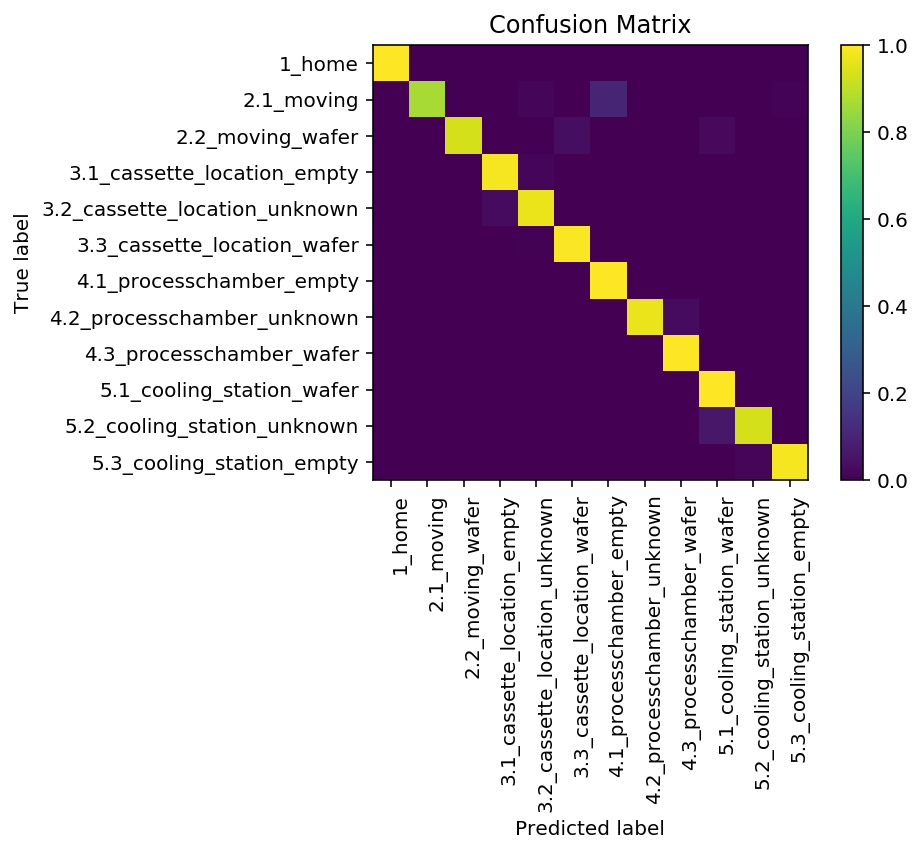

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# generate confusion matrix and normalize
confusion = confusion_matrix(confusion_labels, confusion_predictions)
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# discard labels that are not in the data
confusion_classes = unique_labels(confusion_labels, confusion_predictions)
confusion_classes = [label_name[i][1] for i in confusion_classes]

# setup plot
fig, ax = plt.subplots()
im = ax.imshow(confusion, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(confusion.shape[1]),
    yticks=np.arange(confusion.shape[0]),
    xticklabels=confusion_classes, yticklabels=confusion_classes,
    title="Confusion Matrix",
    ylabel='True label',
    xlabel='Predicted label'
)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# save and show
plt.savefig("test.svg", format="svg", bbox_inches='tight')
plt.show()